In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
raw_path = os.path.join('..','artifacts','raw')

anime_list = pd.read_csv(raw_path+'\\animelist.csv',low_memory=True,usecols=["user_id","anime_id","rating"],nrows=5000000)

In [3]:
anime_list

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
...,...,...,...
4999995,16508,21405,8
4999996,16508,24913,9
4999997,16508,37451,7
4999998,16508,28755,8


In [4]:
# only those users who has rated more than equal to 400 times

n_ratings = anime_list["user_id"].value_counts()
anime_list = anime_list[anime_list["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [5]:
anime_list

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
4999916,16507,8985,0
4999917,16507,5454,0
4999918,16507,15911,0
4999919,16507,878,0


In [6]:
min_rating = min(anime_list["rating"])
max_rating = max(anime_list["rating"])

max_rating

10

In [7]:
avg_rating = np.mean(anime_list["rating"])

avg_rating

np.float64(4.122732695114736)

In [8]:
# normalizing the ratings

epsilon = 1e-6
anime_list["rating"] = anime_list["rating"].apply(
    lambda x: ((x - min_rating) + epsilon) / ((max_rating - min_rating) + epsilon)
)
anime_list["rating"] = anime_list["rating"].round(7)

In [9]:
anime_list["rating"]

213        1.000000e-07
214        1.000000e+00
215        1.000000e-07
216        1.000000e-07
217        1.000000e-07
               ...     
4999916    1.000000e-07
4999917    1.000000e-07
4999918    1.000000e-07
4999919    1.000000e-07
4999920    1.000000e-07
Name: rating, Length: 3246641, dtype: float64

In [10]:
anime_list.duplicated().sum()

np.int64(0)

In [11]:
anime_list.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [12]:
user_ids = anime_list["user_id"].unique().tolist()

## 11054 : 12  -> user2user encoded
## 12 : 11054 ---> usser2userdecocded
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}

anime_list["user"] = anime_list["user_id"].map(user2user_encoded)

In [13]:
n_users = len(user2user_decoded)

n_users

4203

In [14]:
anime_ids = anime_list["anime_id"].unique().tolist()

anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}

anime_list["anime"] = anime_list["anime_id"].map(anime2anime_encoded)

In [15]:
n_anime = len(anime2anime_decoded)

n_anime

17149

In [16]:
# randomly samples 100% of the rows, effectively shuffling the entire DataFrame

anime_list = anime_list.sample(frac=1,random_state=23).reset_index(drop=True)

anime_list.head()

,user_id,anime_id,rating,user,anime
0,6721,40454,1.000000e-07,1674,1782
1,12968,7805,9.000000e-01,3297,2235
2,1469,326,5.000000e-01,390,2387
3,7196,34662,1.000000e+00,1810,1789
4,7175,34134,5.000000e-01,1804,62


In [17]:
X = anime_list[["user","anime"]].values

y = anime_list["rating"]

In [18]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [19]:
X_train

array([[2820,  528],
       [  66,  751],
       [4143, 1049],
       ...,
       [  60, 1510],
       [2657, 5151],
       [ 710,   41]], shape=(2272648, 2))

In [20]:
X_train_array = [X_train[:,0],X_train[:,1]]

X_test_array = [X_test[:,0],X_test[:,1]]

# we are seperating the user and anime because we want to create different embeddings for both 

**Reason for creating different embeddings**

- user IDs represent people — each with unique preferences, behaviors, and interaction histories.
- anime IDs represent items — each with its own genre, popularity, and appeal.

magine you’re building a recommendation engine:
- You want the model to learn what kind of anime a user tends to like.
- You want the anime embeddings to capture what kind of users tend to watch them.
If you used a shared embedding layer, the model would treat user ID 42 and anime ID 42 as the same thing — which would completely confuse the learning process.

🔍 Analogy: Think of it like coordinates
- Users live in one part of the map (preferences space)
- Anime lives in another (content space)
- The dot product between their embeddings tells you how close they are — i.e., how likely a user is to enjoy that anime.


In [21]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

In [22]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

model = RecommenderNet()

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [24]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

In [25]:
# Ramp-up phase (epoch < ramup_epochs)
#   • Linearly increases the learning rate from  to  over
# 2. Sustain phase (epoch < ramup_epochs + sustain_epochs)
#   • Keeps the learning rate constant at  for a few epochs (in your case,  epochs)
# 3. Decay phase (3. Decay phase (epoch >= ramup_epochs + sustain_epochs)
#   • Applies exponential decay to gradually reduce the learning rate toward


def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [26]:
lr = LearningRateScheduler(
    lambda epoch: lrfn(epoch=epoch),verbose=0
)

In [27]:
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

# early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [28]:
my_callbacks = [model_checkpoint,lr]

In [29]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.7034 - mae: 0.3633 - mse: 0.1605 - val_loss: 0.6931 - val_mae: 0.3606 - val_mse: 0.1554 - learning_rate: 1.0000e-05
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.7019 - mae: 0.3628 - mse: 0.1598 - val_loss: 0.6935 - val_mae: 0.3611 - val_mse: 0.1557 - learning_rate: 1.8000e-05
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.6996 - mae: 0.3620 - mse: 0.1587 - val_loss: 0.6963 - val_mae: 0.3620 - val_mse: 0.1570 - learning_rate: 2.6000e-05
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.6967 - mae: 0.3610 - mse: 0.1573 - val_loss: 0.6978 - val_mae: 0.3625 - val_mse: 0.1577 - learning_rate: 3.4000e-05
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 0.6935 - mae: 0.3599 - mse: 0.1557 - val_loss: 0.6970 - val_mae: 0.3623 - val_mse: 0.1574 - learning_rate: 4.2000e-05
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.6901 - mae: 0.3588 - mse: 0.1540 - v

In [30]:
model.load_weights(checkpoint_filepath)

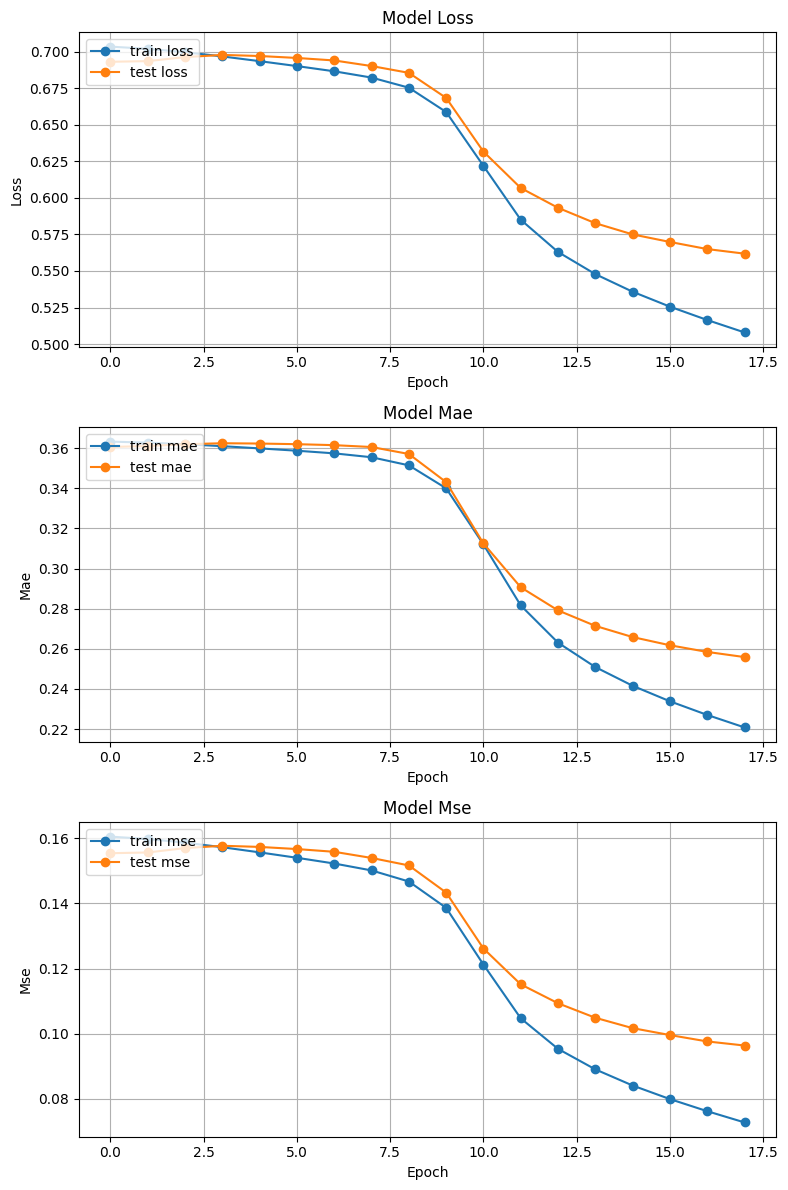

In [32]:
import matplotlib.pyplot as plt

metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [33]:
model_path = os.path.join("..","artifacts","models")
os.makedirs(model_path,exist_ok=True)

model.save(model_path+"\\recommender.keras")

In [34]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

anime_weights = extract_weights("anime_embedding",model)

user_weights = extract_weights("user_embedding",model)

In [36]:
user_weights

array([[-0.08064797,  0.027721  ,  0.09460378, ...,  0.13548763,
        -0.04740608,  0.00310957],
       [ 0.03178439,  0.13594583,  0.1668356 , ...,  0.04708705,
        -0.08004081,  0.06403312],
       [ 0.01260312, -0.00647316,  0.02209338, ...,  0.0617683 ,
        -0.17731898,  0.11798836],
       ...,
       [ 0.07310908,  0.04050725,  0.18319516, ...,  0.04713871,
         0.055448  ,  0.01930499],
       [ 0.15139578,  0.06736951, -0.10469243, ...,  0.06904402,
        -0.10274331, -0.01779267],
       [-0.10272326, -0.10188887,  0.1108491 , ..., -0.06022221,
        -0.00323383, -0.06743345]], shape=(4203, 128), dtype=float32)

In [ ]:
help(LearningRateScheduler)